In [45]:
%load_ext autoreload
%autoreload 2

import sympy 
import numpy as np 
import pandas as pd 
import tensorflow as tf
from utilities.circuit_database import CirqTranslater
from utilities.templates import *
from utilities.variational import Minimizer
from utilities.misc import get_qubits_involved, reindex_symbol, shift_symbols_down
import matplotlib.pyplot as plt 
import tensorflow_quantum as tfq
import cirq

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
translator = CirqTranslater(n_qubits = 2)
qubits = translator.qubits
circuit = cirq.Circuit([cirq.H.on(qubits[0]), cirq.CNOT(qubits[0], qubits[1])])

In [81]:
isinstance(circuit_db, pd.core.frame.DataFrame)

True

In [126]:
def construct_compiling_circuit(translator, v_to_compile):
    """
    compiling single-qubit unitary (for the moment)
    
    v_to_compile is a cirq.Circuit object (single-qubit for the moment)
    """
    qubits = translator.qubits[:2]
    systems = qubits[:int(len(qubits)/2)]
    ancillas = qubits[int(len(qubits)/2):]

    forward_bell = [translator.number_of_cnots + 3*translator.n_qubits + i for i in range(int(translator.n_qubits/2))]
    forward_bell += [translator.cnots_index[str([k, k+int(translator.n_qubits/2)])] for k in range(int(translator.n_qubits/2))]
    bell_db = pd.DataFrame([gate_template(k, trainable=False) for k in forward_bell])
    u1s = u1_db(translator, 0, params=False)
    target_unitary_db = pd.DataFrame([gate_template(ind=-1, param_value = np.conjugate(v_to_compile), trainable=False, qubits=[1])])
    backward_bell_db = bell_db[::-1]
    id_comp = concatenate_dbs([bell_db, u1s, target_unitary_db, backward_bell_db])


    return translator.give_circuit(id_comp, unresolved=False)

In [127]:
compile_circuit, compile_circuit_db = construct_compiling_circuit(translator, cirq.Circuit([cirq.I.on(translator.qubits[0])]).unitary())

In [128]:
compile_circuit

(0, 0): ───H───@───Rz(th_0)──────────Rx(th_1)───Rz(th_2)───@───H───
               │                                           │
               │   ┌             ┐                         │
(0, 1): ───────X───│1.-0.j 0.-0.j│─────────────────────────X───────
                   │0.-0.j 1.-0.j│
                   └             ┘

In [130]:
minimizer = Minimizer(translator, mode="compiling", hamiltonian="Z")

computing ground state energy...


In [132]:
cost, resolver, history = minimizer.minimize([compile_circuit], symbols=translator.get_symbols(compile_circuit_db))

ValueError: Cannot serialize op cirq.MatrixGate(np.array([[(1-0j), -0j], [-0j, (1-0j)]], dtype=np.complex128)).on(cirq.GridQubit(0, 1)) of type <class 'cirq.ops.matrix_gates.MatrixGate'>

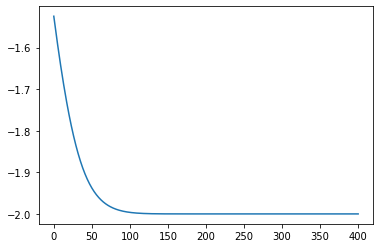

In [19]:
plt.plot(history.history["cost"])

In [23]:
np.array(list(resolver.values()))/np.pi

array([ 2.2210956, -4.9999986,  1.2210971], dtype=float32)

In [30]:
q = qubits[0]
cirq.Circuit([cirq.rz(2.22*np.pi).on(q), cirq.rx(-5*np.pi).on(q), cirq.rz(1.22*np.pi).on(q)]).unitary()

array([[ 0.+0.00000000e+00j, -1.-1.11022302e-16j],
       [ 1.-1.66533454e-16j, -0.+0.00000000e+00j]])

In [33]:
minimizer.model(tfq.convert_to_tensor([circuit]))

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-2.], dtype=float32)>

2

In [ ]:
tfqci = tfq.convert_to_tensor([circuit])
ee = model.fit(x=tfqci, y=tf.zeros(1,), verbose=0, epochs=100, batch_size=1)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.5682691], dtype=float32)>

In [24]:
u1_dbb = pd.DataFrame([gate_template(k, trainable=True, param_value = 0.1) for k in u1(translator, 0)])

[{'ind': 2,
  'symbol': None,
  'param_value': 0.1,
  'trainable': True,
  'block_id': 0},
 {'ind': 4,
  'symbol': None,
  'param_value': 0.1,
  'trainable': True,
  'block_id': 0},
 {'ind': 2,
  'symbol': None,
  'param_value': 0.1,
  'trainable': True,
  'block_id': 0}]

In [2]:
def get_positional_dbs(circuit, circuit_db):

    qubits_involved = get_qubits_involved(circuit, circuit_db)
    
    gates_on_qubit = {q:[] for q in qubits_involved}
    on_qubit_order = {q:[] for q in qubits_involved}

    for order_gate, ind_gate in enumerate( circuit_db["ind"]):
        if ind_gate < translator.number_of_cnots:
            control, target = translator.indexed_cnots[str(ind_gate)]
            gates_on_qubit[control].append(ind_gate)
            gates_on_qubit[target].append(ind_gate)
            on_qubit_order[control].append(order_gate)                
            on_qubit_order[target].append(order_gate)  
        else:
            gates_on_qubit[(ind_gate-translator.n_qubits)%translator.n_qubits].append(ind_gate)
            on_qubit_order[(ind_gate-translator.n_qubits)%translator.n_qubits].append(order_gate)        
    return gates_on_qubit, on_qubit_order

In [62]:
def rule_1(translator, simplified_db, on_qubit_order, gates_on_qubit):
    simplification = False
    
    for q, qubit_gates_path in gates_on_qubit.items():
        if simplification is True:
            break
        for order_gate_on_qubit, ind_gate in enumerate(qubit_gates_path):
            if ind_gate < translator.number_of_cnots:
                control, target = translator.indexed_cnots[str(ind_gate)]
                if (q == control) and (order_gate_on_qubit == 0):
                    pos_gate_to_drop = on_qubit_order[q][order_gate_on_qubit]
                    
                    block_id = circuit_db.iloc[pos_gate_to_drop]["block_id"]
                    simplified_db.loc[int(pos_gate_to_drop)+0.1] = gate_template(translator.number_of_cnots + translator.n_qubits + control, param_value=0.0, block_id=circuit_db.iloc[0]["block_id"])
                    simplified_db.loc[int(pos_gate_to_drop)+0.11] = gate_template(translator.number_of_cnots + translator.n_qubits + target, param_value=0.0, block_id=circuit_db.iloc[0]["block_id"])
                    
                    simplified_db = simplified_db.drop(labels=[pos_gate_to_drop],axis=0)
                    
                    simplification = True
                    break
    simplified_db = simplified_db.sort_index().reset_index(drop=True)
    return simplification, simplified_db


def rule_2(translator, simplified_db, on_qubit_order, gates_on_qubit):
    simplification = False
    
    for q, qubit_gates_path in gates_on_qubit.items():
        if simplification is True:
            break
        for order_gate_on_qubit, ind_gate in enumerate(qubit_gates_path[:-1]):
            
            next_ind_gate = qubit_gates_path[order_gate_on_qubit+1]
            if (ind_gate < translator.number_of_cnots) and (ind_gate == next_ind_gate):
                control, target = translator.indexed_cnots[str(ind_gate)]
                not_gates_in_between = False
                this_qubit = q
                other_qubits = [control, target]
                other_qubits.remove(q)
                other_qubit = other_qubits[0]
                
                ## now we need to check what happens in the other_qubit
                for qord_other, ind_gate_other in enumerate(gates_on_qubit[other_qubit][:-1]):
                    if (ind_gate_other == ind_gate) and (gates_on_qubit[other_qubit][qord_other +1] == ind_gate):
                        ## if we append the CNOT for q and other_q on the same call, and also for the consecutive
                        ## note that in between there can be other calls for other qubits
                        order_call_q = on_qubit_order[q][order_gate_on_qubit]
                        order_call_other_q = on_qubit_order[other_qubit][qord_other]
                        
                        order_call_qP1 = on_qubit_order[q][order_gate_on_qubit+1]
                        order_call_other_qP1 = on_qubit_order[other_qubit][qord_other+1]
                        
                        ## then it's kosher to say they are consecutively applied (if only looking at the two qubits)
                        if (order_call_q == order_call_other_q) and (order_call_qP1 == order_call_other_qP1):
                            
                            pos_gate_to_drop = on_qubit_order[q][order_gate_on_qubit]
                            simplified_db = simplified_db.drop(labels=[pos_gate_to_drop],axis=0)
                            pos_gate_to_drop = on_qubit_order[q][order_gate_on_qubit+1]
                            simplified_db = simplified_db.drop(labels=[pos_gate_to_drop],axis=0)

                            simplification = True
                            break
                if simplification is True:
                    break
    simplified_db = simplified_db.reset_index(drop=True)
    return simplification, simplified_db



def rule_3(translator, simplified_db, on_qubit_order, gates_on_qubit):
    simplification = False
    for q, qubit_gates_path in gates_on_qubit.items():
        if simplification is True:
            break
        for order_gate_on_qubit, ind_gate in enumerate(qubit_gates_path[:-1]):
            if order_gate_on_qubit == 0 and (translator.number_of_cnots <= ind_gate< translator.number_of_cnots+ translator.n_qubits ):
                pos_gate_to_drop = on_qubit_order[q][order_gate_on_qubit]
                simplified_db = simplified_db.drop(labels=[pos_gate_to_drop],axis=0)
                simplified_db = simplified_db.reset_index(drop=True)
                simplified_db = shift_symbols_down(translator, pos_gate_to_drop, simplified_db)
                simplification = True
                break
    return simplification, simplified_db



def rule_4(translator, simplified_db, on_qubit_order, gates_on_qubit):
    """
    Repeated rotations: add the values
    """
    simplification = False
    for q, qubit_gates_path in gates_on_qubit.items():
        if simplification is True:
            break
        for order_gate_on_qubit, ind_gate in enumerate(qubit_gates_path[:-1]):
            if ind_gate>=translator.number_of_cnots:
                next_ind_gate = qubit_gates_path[order_gate_on_qubit+1]
                if next_ind_gate == ind_gate:
                    pos_gate_to_drop = on_qubit_order[q][order_gate_on_qubit]
                    pos_gate_to_add = on_qubit_order[q][order_gate_on_qubit+1]
                    
                    value_1 = simplified_db.loc[pos_gate_to_drop]["param_value"]
                    value_2 = simplified_db.loc[pos_gate_to_add]["param_value"]
                    
                    simplified_db.loc[pos_gate_to_add] = simplified_db.loc[pos_gate_to_add].replace(to_replace=value_2, value=value_1 + value_2)
                    simplified_db = simplified_db.drop(labels=[pos_gate_to_drop],axis=0)
                    simplified_db = simplified_db.reset_index(drop=True)

                    simplified_db = shift_symbols_down(translator, pos_gate_to_drop, simplified_db)
                    simplification = True
                    break
    return simplification, simplified_db

def apply_rule(original_circuit_db, rule, **kwargs):
    max_cnt = kwargs.get('max_cnt',10)
    simplified, cnt = True, 0
    original_circuit, original_circuit_db = translator.give_circuit(original_circuit_db)
    gates_on_qubit, on_qubit_order = get_positional_dbs(original_circuit, original_circuit_db)
    simplified_db = original_circuit_db.copy()
    while simplified and cnt < max_cnt:
        simplified, simplified_circuit_db = rule(translator, simplified_db, on_qubit_order, gates_on_qubit)
        circuit, simplified_db = translator.give_circuit(simplified_circuit_db)
        gates_on_qubit, on_qubit_order = get_positional_dbs(circuit, simplified_db)
        cnt+=1
    return cnt, simplified_db

In [63]:
translator = CirqTranslater(3)
db1 = u1_layer(translator)
db2 = cnot_layer(translator, block_id = 2)
circuit_db = concatenate_dbs([db1, db1])
circuit, circuit_db  = translator.give_circuit(circuit_db)
gates_on_qubit, on_qubit_order = get_positional_dbs(circuit, circuit_db)

In [64]:
cnt, simplified_db = apply_rule(circuit_db, rule_4)

In [65]:
translator.give_circuit(simplified_db)[0]

(0, 0): ───Rz(-0.655π)───Rx(-0.49π)────Rz(1.21π)────Rx(-0.49π)────Rz(1.86π)────

(0, 1): ───Rz(0.175π)────Rx(-0.817π)───Rz(-1.45π)───Rx(-0.817π)───Rz(-1.62π)───

(0, 2): ───Rz(1.82π)─────Rx(-1.82π)────Rz(1.25π)────Rx(-1.82π)────Rz(-0.57π)───